# 1. Import Necessary Libraries

In [1]:
!conda env export > environment.yml

In [1]:
import cv2
import math
import numpy as np
import os, os.path
import scipy

from matplotlib import pyplot as plt
from numpy.linalg import inv
from PIL import Image
from pylab import *
from random import *
from scipy import optimize
from sklearn.metrics import roc_curve

# 2. Load Dataset

In [8]:
""" path to dataset """
def directory(n):
    if n == 1:
        ds_dir = "../dataset/train/faces"            # to training face images
    elif n == 2:
        ds_dir = "../dataset/train/non_faces"        # to training non-face images
    elif n == 3:
        ds_dir = "../dataset/test/faces"             # to test face images
    else:
        ds_dir = "../dataset/test/non_faces"         # to test non-face images

            
    val_extension = [".jpg"]                                      # .jpg is valid extension
    val_extension = [item.lower() for item in val_extension]

    
    """ append images that have .jpg to image_list """
    image_list = []
    for root, dirs, files in os.walk(ds_dir):
        for file in files:
            with open(os.path.join(root, file), "r") as auto:
                extension = os.path.splitext(file)[1]
                if extension.lower() not in val_extension:       # if read a file that is not .jpg img, ignore
                    continue
                image_list.append(os.path.join(root, file))
    
    
    """ flatten images"""
    flattened_img = []
    for img_in_list in image_list:                             
        image = cv2.imread(img_in_list)                           # read all images in image list
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)        # covert images to grayscale
        flat = gray_img.flatten()                                 # flatten grayscale images
        flattened_img.append(flat)                                # append to list of flattened images
    
    
    return flattened_img

# 3. Models

Select an apprpriate model block to run and then run "Rate Calculation & RoC Plotting."

### 3.a. Model 1 - Gaussian

In [9]:
""" function to calculate mean and covariance """
def parameters(flattened_space):
    mean = np.mean(flattened_space, axis=0)
    cov = np.cov(np.transpose(flattened_space))
    return mean, cov


""" function to calculate norm """
def Norm(flattened_space_test, cov, mean):
    lpdf = np.zeros(len(flattened_space_test))
    for i in range(len(flattened_space_test)):
        d = np.matmul((flattened_space_test[i] - mean).transpose(), (inv(cov)))                              # denominator
        d1 = np.matmul(d, (flattened_space_test[i] - mean))                                                  # complete denominator
        pdf = 1/((2*np.pi)**(len(flattened_space_test)/2)*np.linalg.det(cov)**(1/2)) * (np.exp(-0.5*d1))     # calculate pdf
        lpdf[i] = np.log(pdf)                                                                               # take log of pdf
    #print("log likelihood pdf: ", lpdf)                                                                     # check printing
    return lpdf                                                                                              # return log likelihood                                                              # return log likelihood


""" calculate posterior """
def Posterior(test_face, test_non):
    Posterior_face = test_face/(test_face + test_non)
    Posterior_non = test_non/(test_face + test_non)
    return Posterior_face, Posterior_non


###########################################################################################################################


""" flatten face and non-face images in training and test set"""
flattened_train_face = directory(1)
flattened_train_non = directory(2)
flattened_test_face = directory(3)
flattened_test_non = directory(4)


""" call parameters function to calculate mean and covariance of training face/non-face """
mean_f, cov_f = parameters(flattened_train_face)
mean_nf, cov_nf = parameters(flattened_train_non)


""" save some figures for report """
mean_show_f = np.reshape(mean_f,(10,10))
cv2.imwrite('mean_single_gaussian_face.jpg', mean_show_f)

mean_show_nf = np.reshape(mean_nf,(10,10))
cv2.imwrite('mean_single_gaussian_nonface.jpg', mean_show_nf)

cv2.imwrite('cov_single_gaussian_face.jpg', cov_f)
cv2.imwrite('cov_single_gaussian_nonface.jpg', cov_nf)


""" call norm to calculate pdf and return log likelihood  """
lpdf_ff = Norm(flattened_test_face, cov_f, mean_f)            # log likelihood of face wrt face
lpdf_fn = Norm(flattened_test_face, cov_nf, mean_nf)          #         "         face wrt non-face
lpdf_nn = Norm(flattened_test_non, cov_nf, mean_nf)           #         "         non-face wrt to non-face
lpdf_nf = Norm(flattened_test_non, cov_f, mean_f)             #         "         non-face wrt to face

<ipython-input-9-9c33da823843>:15: RuntimeWarning: divide by zero encountered in log
  lpdf[i] = np.log(pdf)                                                                               # take log of pdf


### 3.b. Model 2 - Mixture of Gaussians

In [6]:
""" function to calculate mean, covariance, and lamda """
def parameters(N_clusters):
    lamda = np.zeros(N_clusters)
    for i in range(N_clusters):
        lamda[i]= 1 / N_clusters
        
    mean = np.random.randint(0, 255, size = (N_clusters, 100))
    cov = np.zeros((100, 100, N_clusters))
    
    for i in range(N_clusters):
        for j in range(100):
            for k in range(100):
                if j == k:
                    cov[j][k][i] = int((np.random.random())+(1000*(2)))
                else:
                    cov[j][k][i] = 0

    return lamda, mean, cov


""" E-M algorithm """
#--------------------------------------------------------------------------------------------------------------------------
def Estep(N_clusters, flattened_space, lamda, mean, cov):
    pdf = np.zeros((len(flattened_space), N_clusters))
    sum_pdf = np.zeros(len(flattened_space))
    
    for i in range (len(flattened_space)):
        for k in range (N_clusters):
            d = np.matmul((flattened_space[i] - mean[k]).transpose(), (inv(cov[:,:,k])))    # denominator
            d1 = np.matmul(d, ((flattened_space[i] - mean[k])))                             # complete denominator
            pdf[i][k] =  lamda[k] * exp(-0.5*d1)                                            # calculate individual pdfs
        sum_pdf[i] = np.sum(pdf[i])                                                         # sum up all pdfs

    r = np.zeros((len(flattened_space), N_clusters))
    for i in range(len(flattened_space)):
        for j in range(N_clusters):
            r[i][j] = pdf[i][j] / sum_pdf[i]

    r_temp = np.zeros(N_clusters)
    for i in range(N_clusters):
        r_temp[i] = np.sum(r[:,i])

    return r, r_temp


def Mstep(N_clusters, r, r_temp, flattened_space):
    new_lamda = np.zeros(N_clusters)
    for i in range(N_clusters):
        new_lamda[i] = r_temp[i] / np.sum(r_temp)

    r_t = r.transpose()
    new_mean = np.zeros((N_clusters, 100))
    new_mean_temp = np.zeros((len(flattened_space), 100))
    for i in range (N_clusters):
        for j in range(len(flattened_space)):
            for k in range(100):
                new_mean_temp[j][k] = r_t[i][j] * flattened_space[j][k]

        for j in range(100):
            new_mean[i][j] = np.sum(new_mean_temp[:,j])

    final_mean = np.zeros((N_clusters, 100))
    for j in range(N_clusters):
        for i in range(100):
            final_mean[j][i] = ((new_mean[j][i] - np.min(new_mean[j,:]))/ (np.max(new_mean[j,:])-np.min(new_mean[j,:]))) * 255
            
    new_cov = np.zeros((100,100, N_clusters))
    for i in range(N_clusters):
        temp1 = np.zeros((len(flattened_space), 100))
        temp2 = np.zeros((len(flattened_space), 100))
        temp1_1 = np.zeros((100, 1))
        temp2_2 = np.zeros((100, 1))
        for j in range(len(flattened_space)):
            temp1[j] = (flattened_space[j] - new_mean[i])
            temp2[j] = temp1[j] * r[j][i]
        for k in range(100):
            temp1_1[k] = np.sum(temp1[:,k])
            temp2_2[k] = np.sum(temp2[:,k])
            
        new_cov_temp = np.matmul(temp1_1, (temp2_2).transpose())
        new_cov[:,:,i] = new_cov_temp / np.sum(r_temp[i])

    final_cov = np.zeros((100, 100, N_clusters))
    for j in range(N_clusters):
        for i in range(100):
            for k in range(100):
                if i == k:
                    final_cov[i][k][j] = (((new_cov[i][k][j] - np.min(new_cov[:,:,j])) / (np.max(new_cov[:,:,j])-np.min(new_cov[:,:,j]))) + 10*1000)
                else:
                    final_cov[i][k][j] = 0

    return new_lamda, final_mean, final_cov
#--------------------------------------------------------------------------------------------------------------------------


""" function to calculate norm """
def Norm(N_clusters, flattened_space_test, lamda, mean, cov):
    pdf = np.zeros((len(flattened_space_test), N_clusters))
    sum_pdf = np.zeros(len(flattened_space_test))
    for i in range (len(flattened_space_test)):
        for k in range (N_clusters):
            d = np.matmul((flattened_space_test[i] - mean[k]).transpose(), (inv(cov[:,:,k])))
            d1 = np.matmul(d,((flattened_space_test[i] - mean[k])))
            pdf[i][k] =  lamda[k] * exp(-0.5*d1)
        sum_pdf[i] = np.sum(pdf[i])
    return  sum_pdf


""" calculate posterior """
def Posterior(test_face, test_non):
    Posterior_face = test_face / (test_face + test_non)
    Posterior_non = test_non / (test_face + test_non)
    return Posterior_face, Posterior_non


###########################################################################################################################


""" set some desired # iterations and clusters"""
N_clusters = 4
iteration = 9


""" flatten face and non-face images in training and test set"""
flattened_train_face = directory(1)
flattened_train_non = directory(2)
flattened_test_face = directory(3)
flattened_test_non = directory(4)


""" call parameters function to calculate mean, covariance, and lamda of training face/non-face """
lamda_f, mean_f, cov_f = parameters(N_clusters)
lamda_nf, mean_nf, cov_nf = parameters(N_clusters)


""" call 2 functions to perform Estep and Mstep in E-M algorithm  for training face/non-face """
for i in range(iteration):
    if i < iteration:
        print("iteration: ", i)    #check printing
        r, r_temp = Estep(N_clusters, flattened_train_face, lamda_f, mean_f, cov_f)
        lamda_f, mean_f, cov_f = Mstep(N_clusters, r, r_temp, flattened_train_face)

        r_non, r_non_temp = Estep(N_clusters, flattened_train_non, lamda_nf, mean_nf, cov_nf)
        lamda_nf, mean_nf, cov_nf = Mstep(N_clusters, r_non, r_non_temp, flattened_train_non)

#print("mean: ", mean_f)      # check printing


""" save some figures for report """
for i in range(N_clusters):
    mean_show_f = np.reshape(mean_f[i],(10,10))
    cv2.imwrite('mean_mixtureGaussian_face_' + str(i) +'.jpg', mean_show_f)

for i in range(N_clusters):
    mean_show_nf = np.reshape(mean_nf[i],(10,10))
    cv2.imwrite('mean_mixtureGaussian_nonface_' + str(i) + '.jpg',mean_show_nf)

for i in range(N_clusters):
    cv2.imwrite('cov_mixtureGaussian_face_' + str(i) + '.jpg',cov_f)

for i in range(N_clusters):
    cv2.imwrite('cov_mixtureGaussian_nonface_'+ str(i) +'.jpg', cov_nf)


""" call norm to calculate pdf and return log likelihood  """
lpdf_ff = Norm(N_clusters, flattened_test_face, lamda_f, mean_f, cov_f)
lpdf_fn = Norm(N_clusters, flattened_test_face, lamda_nf, mean_nf, cov_nf)
lpdf_nn = Norm(N_clusters, flattened_test_non, lamda_nf, mean_nf, cov_nf)
lpdf_nf = Norm(N_clusters, flattened_test_non, lamda_f, mean_f, cov_f)

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8


# 4. Rate Calculation & RoC Plotting

true-positive rate:  0.03
true-negative rate:  0.88
false-positve rate:  0.56
fale-negative rate:  0.18
misclassification rate:  0.37


<ipython-input-9-9c33da823843>:23: RuntimeWarning: invalid value encountered in true_divide
  Posterior_non = test_non/(test_face + test_non)


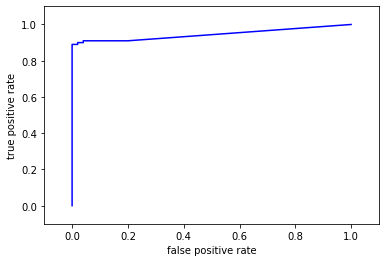

In [10]:
""" call Posterior """
posterior_test_ff, posterior_test_fn  = Posterior(lpdf_ff, lpdf_fn)
posterior_test_nf, posterior_test_nn  = Posterior(lpdf_nf, lpdf_nn)


""" count # true-positive """
countTP = 0
for i in range(len(posterior_test_ff)):          # can use len of other posterior since they are same, same for other counts
    if posterior_test_ff[i] > posterior_test_nn[i]:
        countTP = countTP + 1
print("true-positive rate: ", float(countTP)/len(posterior_test_ff))


""" count # true-negative """
countTN = 0
for i in range(len(posterior_test_ff)):
    if posterior_test_nn[i] > posterior_test_ff[i]:
        countTN = countTN + 1
print("true-negative rate: ", float(countTN)/len(posterior_test_ff))


""" count # false-positive """
countFP = 0
for i in range(len(posterior_test_ff)):
    if posterior_test_nf[i] > 0.55:               # set threshold to 0.55 can be any other number
        countFP = countFP + 1
print("false-positve rate: ", float(countFP)/len(posterior_test_ff))


""" count # false-negative """
countFN = 0
for i in range(len(posterior_test_ff)):
    if posterior_test_fn[i] > 0.55:
        countFN = countFN + 1
print("fale-negative rate: ", float(countFN)/len(posterior_test_ff))


""" calculate misclassicfication rate """
mcr = (float(countFP + countFN)) / (len(posterior_test_ff) + len(posterior_test_ff))
print("misclassification rate: ", mcr)


""" plottting"""
posterior_plot = np.append(posterior_test_ff, posterior_test_nf)
labels = np.append(np.ones(100), np.zeros(100))

fpr, tpr, _ = roc_curve(labels, posterior_plot, pos_label = 0)        # 0 for model 1, 1 for model 2
plt.plot(fpr, tpr, color='blue')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.show()